In [19]:
import torch
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical

In [1040]:
means = torch.tensor([[-1, 1], [0,0], [1, 1]]).float()

m = MultivariateNormal(means, torch.stack([torch.eye(2)]*3))

In [1041]:
mm = MixtureSameFamily(Categorical(torch.tensor([0.2]*3)), m)

In [1042]:
samples = mm.sample(torch.tensor([10000]))

In [1043]:
from matplotlib import pyplot as plt

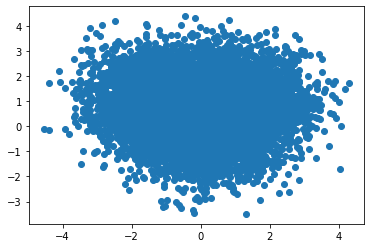

In [1044]:
plt.scatter(samples[:, 0], samples[:, 1])

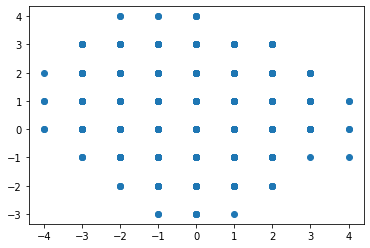

In [1045]:
plt.scatter(samples.int()[:, 0], samples.int()[:, 1])

(array([[  0.,   0.,   0.,   0.,   6.,   0.,   5.,   2.,   0.,   0.],
        [  0.,   0.,   3.,   9.,  29.,  37.,  43.,  17.,   9.,   3.],
        [  0.,   4.,   9.,  55., 134., 161., 141.,  84.,  10.,   1.],
        [  3.,   7.,  52., 193., 370., 438., 325., 142.,  38.,   5.],
        [  7.,  20., 118., 312., 568., 643., 420., 171.,  33.,   7.],
        [  5.,  30., 158., 322., 589., 650., 438., 225.,  52.,   7.],
        [  1.,  23.,  76., 223., 423., 496., 370., 164.,  38.,   3.],
        [  1.,   5.,  35.,  76., 200., 256., 169.,  85.,  13.,   4.],
        [  0.,   2.,   7.,  17.,  45.,  64.,  42.,  15.,  10.,   1.],
        [  0.,   0.,   1.,   1.,   4.,  10.,   7.,   2.,   1.,   0.]]),
 array([-4.53365135, -3.65128098, -2.7689106 , -1.88654022, -1.00416985,
        -0.12179947,  0.76057091,  1.64294128,  2.52531166,  3.40768204,
         4.29005241]),
 array([-3.49419641, -2.70572972, -1.91726303, -1.12879634, -0.34032965,
         0.44813704,  1.23660374,  2.02507043,  2.813537

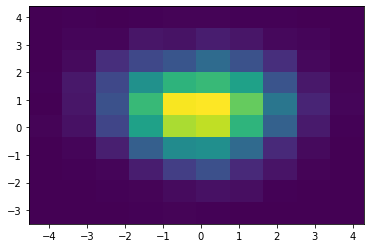

In [1046]:
plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy())

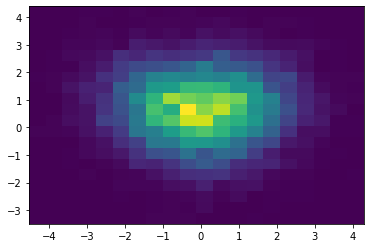

In [1051]:
img, x_grid, y_grid, _ = plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy(), bins = [20, 20])

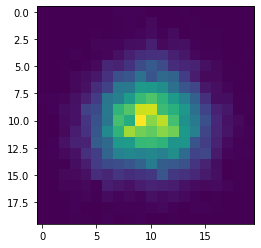

In [1052]:
plt.imshow(img.transpose())

To implement the EM algorithm, we need the truncated normal distribution:

- Implementation of truncated multivariate distribution in R: tmvtnorm package
- This could be useful: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html


In [1053]:
import rpy2
import numpy as np
from rpy2.robjects import numpy2ri
numpy2ri.activate()

In [1054]:
from rpy2.robjects.packages import importr

In [1055]:
import rpy2.robjects as robjects

In [1056]:
tmv = importr("tmvtnorm")

In [1057]:
strr = robjects.r('dim')

In [1058]:
np2vec = robjects.r('as.vector')

In [1059]:
xxx=robjects.r('list(a=5,b=matrix(c(7,8,27,99), nrow=1))')

In [1060]:
xxx[0]

array([5.])

In [1061]:
xxx[1]

array([[ 7.,  8., 27., 99.]])

In [1062]:
np2vec

<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x7efee4c44e00> [RTYPES.CLOSXP]
R classes: ('function',)

In [1063]:
np2vec(means[0].numpy().astype(np.float64)

SyntaxError: unexpected EOF while parsing (2403992266.py, line 1)

In [1064]:
x = robjects.r.rnorm(100)

In [1065]:
x.r_repr

AttributeError: 'numpy.ndarray' object has no attribute 'r_repr'

In [1066]:
mtmvnorm = robjects.r('function(m, l) tmvtnorm::mtmvnorm(as.vector(m), lower=as.vector(l), doComputeVariance=FALSE)$tmean')

In [1067]:
mtmvnorm(means[0].numpy(), l=np.array([0.,0.]))

array([0.52513528, 1.28759997])

In [1068]:
from importlib import reload
import trunc_mvnorm
reload(trunc_mvnorm)

<module 'trunc_mvnorm' from '/home/derek/meta_repo/bliss/case_studies/galaxy_identifiability/trunc_mvnorm.py'>

In [1069]:
tm = trunc_mvnorm.TruncMVNorm()

In [1070]:
tm.mtmvnorm(means[0].numpy(), None, np.array([[0.,0.], [-1., -1.]]), np.array([[1.,1.], [0., 0.]]))

(array([[ 0.38316905,  0.54013777],
        [-0.54013777, -0.38316905]]),
 array([[[ 7.27428861e-02, -3.33066907e-16],
         [-2.22044605e-16,  7.96518248e-02]],
 
        [[ 7.96518248e-02,  2.22044605e-16],
         [ 2.22044605e-16,  7.27428861e-02]]]))

In [1071]:
tm.pmvnorm(means[0].numpy(), None, np.array([[0.,0.], [-1., -1.]]), np.array([[1.,1.], [0., 0.]]))

array([[0.0463905],
       [0.0463905]])

In [1072]:
x_grid

array([-4.53365135, -4.09246616, -3.65128098, -3.21009579, -2.7689106 ,
       -2.32772541, -1.88654022, -1.44535503, -1.00416985, -0.56298466,
       -0.12179947,  0.31938572,  0.76057091,  1.2017561 ,  1.64294128,
        2.08412647,  2.52531166,  2.96649685,  3.40768204,  3.84886723,
        4.29005241])

In [1073]:
y_grid

array([-3.49419641, -3.09996307, -2.70572972, -2.31149638, -1.91726303,
       -1.52302969, -1.12879634, -0.73456299, -0.34032965,  0.0539037 ,
        0.44813704,  0.84237039,  1.23660374,  1.63083708,  2.02507043,
        2.41930377,  2.81353712,  3.20777047,  3.60200381,  3.99623716,
        4.3904705 ])

In [1074]:
from einops import rearrange, repeat, reduce

In [1075]:
x_limits = repeat(np.stack([x_grid[:-1], x_grid[1:]], axis=1), "x p -> x y p", y=y_grid.shape[0]-1)

In [1076]:
y_limits = repeat(np.stack([y_grid[:-1], y_grid[1:]], axis=1), "y p -> x y p", x = x_grid.shape[0]-1)

In [1077]:
x_limits.shape

(20, 20, 2)

In [1078]:
y_limits.shape

(20, 20, 2)

In [1079]:
limits = np.concatenate([x_limits, y_limits], axis=2)

In [1080]:
limits.shape

(20, 20, 4)

In [1081]:
limits[0,0]

array([-4.53365135, -4.09246616, -3.49419641, -3.09996307])

In [1082]:
limits_long = rearrange(limits, "X Y L -> (X Y) L")

In [1083]:
res = tm.mtmvnorm(means[0].numpy(), None, limits_long[:, [0,2]], limits_long[:, [1,3]])
res_mean = rearrange(res[0], "(X Y) A -> X Y A", X=10, Y=10)
res_var = rearrange(res[1], "(X Y) A B -> X Y A B", X=10, Y=10)

EinopsError:  Error while processing rearrange-reduction pattern "(X Y) A -> X Y A".
 Input tensor shape: (400, 2). Additional info: {'X': 10, 'Y': 10}.
 Shape mismatch, 400 != 100

In [1084]:
res_mean.shape

(10, 10, 2)

In [1085]:
limits[-1, -1]

array([3.84886723, 4.29005241, 3.99623716, 4.3904705 ])

In [1086]:
res_mean[-1, -1]

array([6.21822556, 6.58886895])

In [1087]:
res_var[-1, -1]

array([[9.23220109e-03, 2.94246776e+01],
       [2.94246776e+01, 1.00000000e+00]])

In [1088]:
## Basic EM algorithm
from sklearn.cluster import KMeans

samples_pixel = samples.int() + 0.5
km = KMeans(n_clusters=3)
km.fit(samples_pixel)
km.cluster_centers_

array([[0.14549483, 0.36009707],
       [0.12243286, 1.90063191],
       [1.83349237, 0.83778626]])

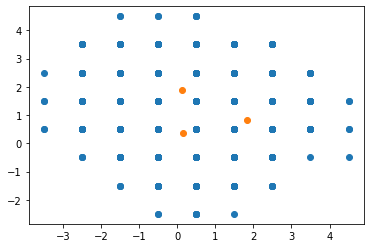

In [1089]:
plt.scatter(samples_pixel[:, 0], samples_pixel[:, 1])
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1])

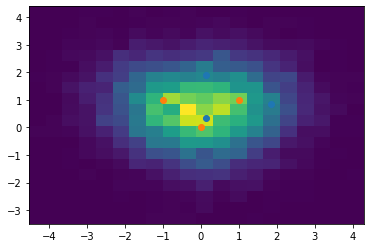

In [1094]:
plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy(), bins=[20,20])
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1])
plt.scatter(means[:, 0], means[:, 1])

In [1095]:
km.cluster_centers_

array([[0.14549483, 0.36009707],
       [0.12243286, 1.90063191],
       [1.83349237, 0.83778626]])

In [1096]:
from tqdm import tqdm

In [1097]:
limits.shape

(20, 20, 4)

In [1098]:
def basic_em(grid, limits, mu_start, pi_start, n_iter):
    grid_long = rearrange(grid, "X Y -> (X Y)")
    limits_long = rearrange(limits, "X Y L -> (X Y) L")
    limits_lower_long = limits_long[:, [0,2]]
    limits_upper_long = limits_long[:, [1,3]]

    
    dim_X, dim_Y = grid.shape
    centered_vals_long = (limits_lower_long + limits_upper_long) / 2
    centered_vals = rearrange(centered_vals_long, "(X Y) L -> X Y L", X=dim_X, Y=dim_Y)
    mu = np.copy(mu_start)
    pi = np.copy(pi_start)
    for _ in tqdm(range(n_iter)):
        ## E-step
        ## Calculate log-probability of each cluster
        probs_list = []
        for j in range(mu.shape[0]):
            ## Get expectation in each pixel
            #res = tm.mtmvnorm(mus[j], None, limits_long[:, [0,2]], limits_long[:, [1,3]])
            #res_mean = rearrange(res[0], "(X Y) A -> X Y A", X=10, Y=10)
            #res_var = rearrange(res[1], "(X Y) A B -> X Y A B", X=10, Y=10)
            ## Calculate the log-probability
            probs_j = tm.pmvnorm(mu[j], None, limits_lower_long, limits_upper_long)
            probs_list.append(probs_j)
        probs_long = np.stack(probs_list)
        #return(probs_long)
        #print(probs_long)
        probs = rearrange(probs_long, "K (X Y) 1 -> K X Y", X=dim_X, Y=dim_Y)
        #return probs
        ## Multiply by the prior
        probs = rearrange(pi, "K -> K 1 1") * probs
        probs = probs / reduce(probs, "K X Y -> 1 X Y", "sum")

        ## M-step
        prob_global = reduce((probs * grid), "K X Y -> K", "sum")
        pi = prob_global / prob_global.sum()
        
        for j in range(mu.shape[0]):
            probs_j = probs[j]
            #print(probs_j.shape)
            W = rearrange(probs_j * grid, "X Y -> X Y 1")
            #eturn probs_j, W
            
            #res = tm.mtmvnorm(mu[j], None, limits_lower_long, limits_upper_long)
            #res_mean = rearrange(res[0], "(X Y) A -> X Y A", X=dim_X, Y=dim_Y)
            res_mean = centered_vals
            #return res_mean
            #return res[0]
            mu[j] = reduce(W * res_mean, "X Y A -> A", "sum")
            mu[j] = mu[j] / (W).sum()
            print(mu[j])
    return mu, pi, probs

In [1099]:
output = basic_em(img, limits, km.cluster_centers_, np.ones(3)/3, 20)

  5%|██▌                                                | 1/20 [00:00<00:09,  2.05it/s]

[-0.34771335  0.16269353]
[-0.41684212  1.48424722]
[1.37948721 0.66478794]


 10%|█████                                              | 2/20 [00:00<00:08,  2.08it/s]

[-0.35017087  0.18962687]
[-0.48639895  1.40847961]
[1.36942177 0.72332774]


 15%|███████▋                                           | 3/20 [00:01<00:08,  2.06it/s]

[-0.34027394  0.19836789]
[-0.55646347  1.36242795]
[1.34761806 0.76396061]


 20%|██████████▏                                        | 4/20 [00:02<00:08,  1.87it/s]

[-0.32253542  0.19813163]
[-0.62700092  1.33106561]
[1.32170302 0.79549892]


 25%|████████████▊                                      | 5/20 [00:02<00:07,  1.95it/s]

[-0.29961021  0.19307034]
[-0.69675965  1.30715087]
[1.29483165 0.82234527]


 30%|███████████████▎                                   | 6/20 [00:02<00:06,  2.04it/s]

[-0.27344719  0.18552378]
[-0.76380244  1.28682832]
[1.26820713 0.84667297]


 35%|█████████████████▊                                 | 7/20 [00:03<00:06,  1.90it/s]

[-0.24573599  0.17696969]
[-0.82612586  1.26811801]
[1.24233019 0.86940284]


 40%|████████████████████▍                              | 8/20 [00:04<00:06,  1.89it/s]

[-0.21795624  0.16833548]
[-0.88214447  1.25020218]
[1.21750282 0.89075808]


 45%|██████████████████████▉                            | 9/20 [00:04<00:05,  1.93it/s]

[-0.19128543  0.16014138]
[-0.93095647  1.23295128]
[1.19399    0.91062598]


 50%|█████████████████████████                         | 10/20 [00:05<00:05,  1.94it/s]

[-0.16652595  0.15261542]
[-0.97237097  1.21656148]
[1.17203751 0.92879719]


 55%|███████████████████████████▌                      | 11/20 [00:05<00:04,  1.97it/s]

[-0.14411117  0.14580181]
[-1.00676028  1.20130158]
[1.15184277 0.94510494]


 60%|██████████████████████████████                    | 12/20 [00:06<00:04,  1.96it/s]

[-0.12417656  0.1396498 ]
[-1.03484303  1.18737399]
[1.13352635 0.95948277]


 65%|████████████████████████████████▌                 | 13/20 [00:06<00:03,  1.99it/s]

[-0.1066547   0.13407324]
[-1.0574854  1.1748677]
[1.1171221 0.9719676]


 70%|███████████████████████████████████               | 14/20 [00:07<00:02,  2.00it/s]

[-0.0913618   0.12898295]
[-1.07556064  1.16376675]
[1.10258547 0.98267536]


 75%|█████████████████████████████████████▌            | 15/20 [00:07<00:02,  1.96it/s]

[-0.07806147  0.12430019]
[-1.08986948  1.15398137]
[1.08981234 0.99176988]


 80%|████████████████████████████████████████          | 16/20 [00:08<00:01,  2.02it/s]

[-0.06650538  0.1199599 ]
[-1.10110628  1.14538097]
[1.07866034 0.99943578]


 85%|██████████████████████████████████████████▌       | 17/20 [00:08<00:01,  1.98it/s]

[-0.05645598  0.11590945]
[-1.10985308  1.13782014]
[1.06896785 1.0058591 ]


 90%|█████████████████████████████████████████████     | 18/20 [00:09<00:01,  1.97it/s]

[-0.0476975  0.1121063]
[-1.11658801  1.1311555 ]
[1.06056843 1.01121542]


 95%|███████████████████████████████████████████████▌  | 19/20 [00:09<00:00,  1.99it/s]

[-0.04003975  0.10851564]
[-1.12169938  1.12525508]
[1.05330069 1.01566375]


100%|██████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.97it/s]

[-0.03331824  0.10510867]
[-1.1255007   1.12000243]
[1.0470142  1.01934418]


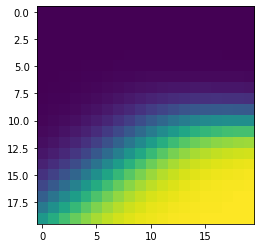

In [1102]:
plt.imshow(output[2][2])

In [1006]:
#output[1].max()

In [1103]:
output

(array([[-0.03331824,  0.10510867],
        [-1.1255007 ,  1.12000243],
        [ 1.0470142 ,  1.01934418]]),
 array([0.40207504, 0.28361472, 0.31431023]),
 array([[[5.77212138e-01, 4.78805422e-01, 3.82038890e-01, ...,
          1.62992938e-03, 1.09753527e-03, 7.38846591e-04],
         [6.85982895e-01, 5.95138475e-01, 4.97296720e-01, ...,
          2.60589358e-03, 1.75528498e-03, 1.18189626e-03],
         [7.77443244e-01, 7.01552932e-01, 6.12699017e-01, ...,
          4.16212604e-03, 2.80500756e-03, 1.88938865e-03],
         ...,
         [6.95580875e-01, 6.16059505e-01, 5.29827728e-01, ...,
          5.60795848e-03, 3.94509962e-03, 2.77370600e-03],
         [5.86981497e-01, 4.99507554e-01, 4.12083921e-01, ...,
          3.49675997e-03, 2.45843786e-03, 1.72775999e-03],
         [4.69106966e-01, 3.82914813e-01, 3.03523335e-01, ...,
          2.17727331e-03, 1.53017433e-03, 1.07510405e-03]],
 
        [[4.22709278e-01, 5.21101759e-01, 6.17855656e-01, ...,
          9.98280222e-01, 9.9881

In [1104]:
np.ones(3)/3

array([0.33333333, 0.33333333, 0.33333333])

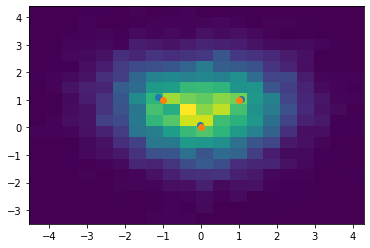

In [1105]:
plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy(), bins=[20,20])
plt.scatter(output[0][:, 0], output[0][:, 1])
plt.scatter(means[:, 0], means[:, 1])

In [936]:
km.cluster_centers_

array([[ 0.50102171,  0.51532567],
       [-1.04844498,  2.2263756 ],
       [ 2.37632251,  2.09686246]])

- Almost spot on when "galaxies" are clearly separated (4, -4), (0,0), (4, 4)
- (FIXED; this was a bug in code) EM converges to center when closer together
- Works well for (1, -1), (0, 0), (4, 4)

- Works for 3